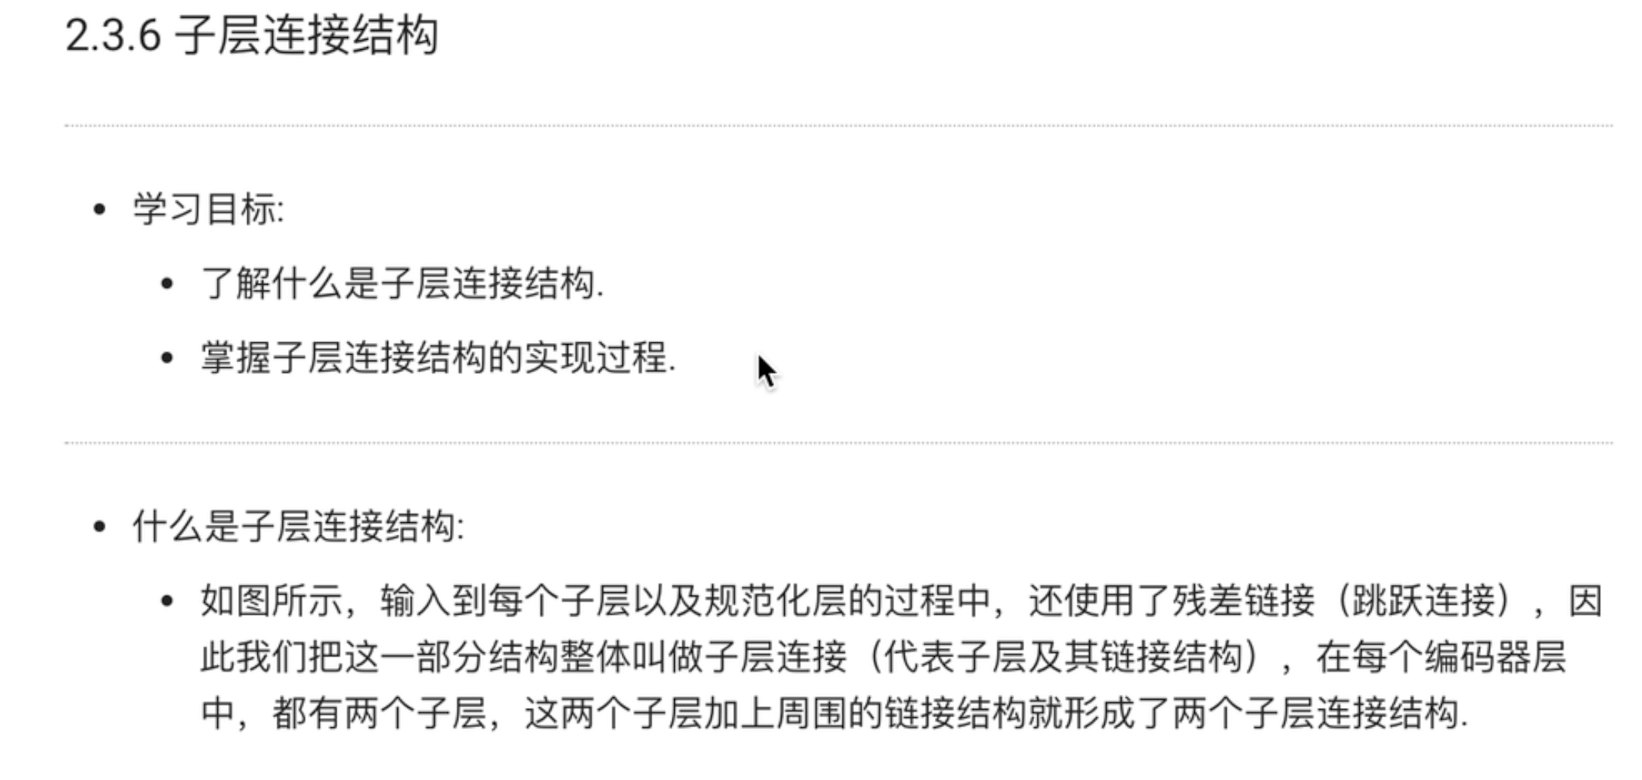

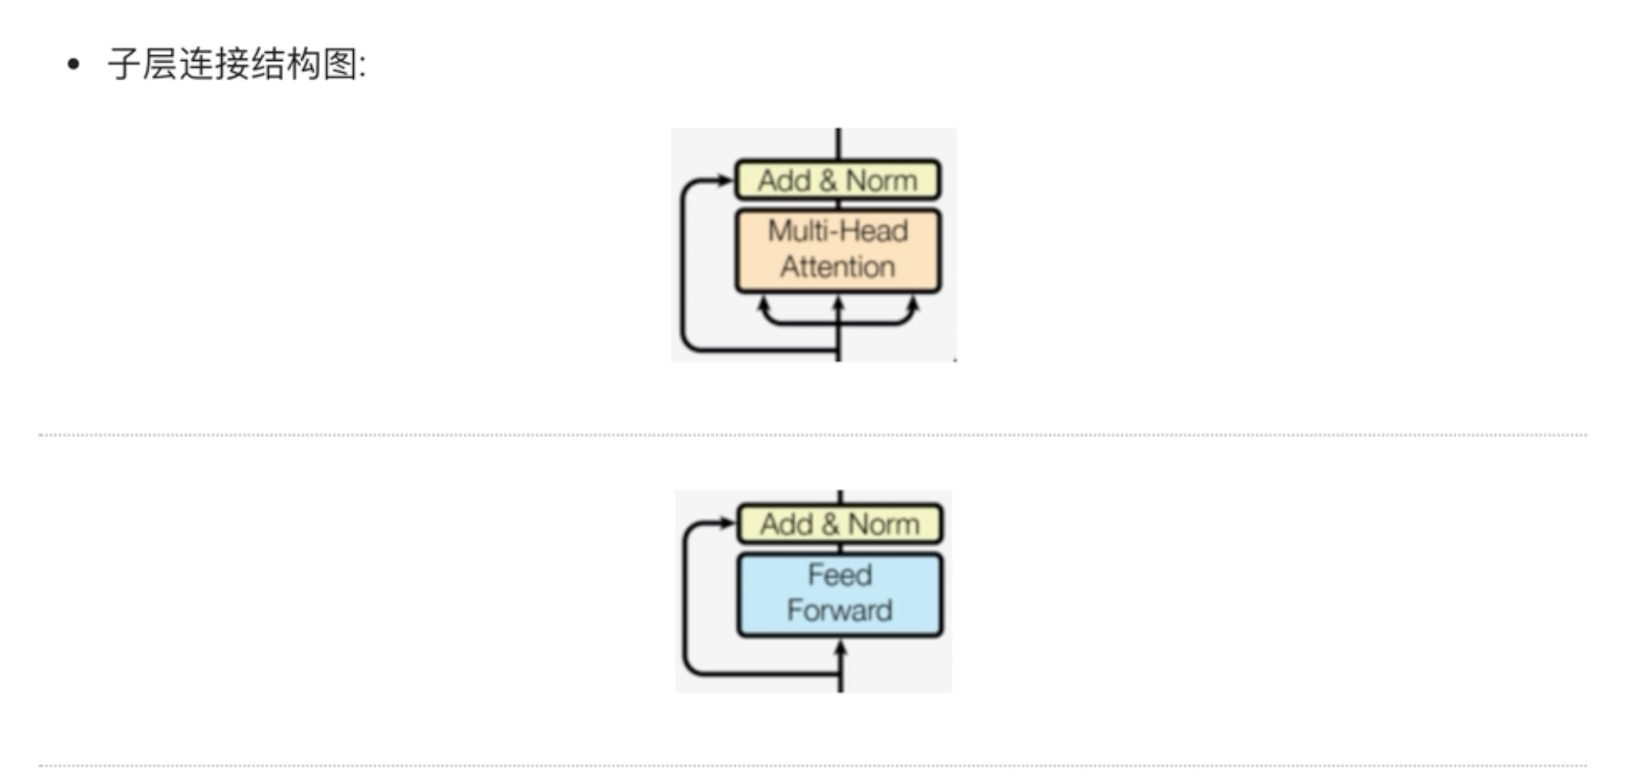

In [1]:
import copy
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.autograd import Variable

In [3]:
# 创建Embedding类来实现文本嵌入层
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        # d_model : 词嵌入的维度
        # vocab : 词表的大小
        super(Embeddings,self).__init__()
        # 定义Embedding层
        self.lut = nn.Embedding(vocab,d_model)
        # 将参数传入类中
        self.d_model = d_model
    def forward(self,x):
        # x: 代表输入进模型的文本通过词汇映射后的数字张量
        return self.lut(x) * math.sqrt(self.d_model)

# 位置编码层
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len=5000):
        # d_model : 代表词嵌入的维度
        # dropout ： 代表Dropout 层的置零比率
        # max_len : 代表每个句子的最长长度
        super(PositionalEncoding,self).__init__()

        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len,d_model)
        position = torch.arange(0,max_len).unsqueeze(1)

        # 定义一个变化矩阵div_term,跳跃式的初始化
        div_term = torch.exp(torch.arange(0,d_model,2) * 
                             -(math.log(10000.0) / d_model))
        # 将前面定义的变化矩阵进行奇数，偶数分别赋值
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)

        # 将二维张量扩充成三维张量
        pe = pe.unsqueeze(0)

        # 将位置编码矩阵注册成模型的buffer，这个buffer不是模型中的参数，不跟随优化器同步更新
        # 注册成buffer后我们就可以在模型保存后重新加载的时候，将这个位置编码和模型参数一同加载进来
        self.register_buffer("pe",pe)
    def forward(self,x):
        # x:代表文本序列的词嵌入表示
        # 首先明确pe的编码太长了，将第二个维度
        # 也就是max_len对应的那个维度缩小成x的句子长度同等的长度
        x = x + Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x)

# 注意力权重的计算
def attention(query,key,value,mask=None,dropout=None):
    # query，key，value：代表注意力的三个输入张量
    # mask：掩码张量
    # dropout:传入的Dropout实例化对象
    # 首先将query的最后一个维度提取出来，代表的是词嵌入的维度
    d_k  = query.size(-1)

    # 按照注意力计算公式，将query和key的转置进行矩阵乘法，然后除以缩放系数
    scores = torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)

    # 判断是否使用掩码张量
    if mask is not None:
        # 利用mask_fill方法，将掩码张量和0进行位置的意义比较，如果等于0，替换成一个非常小的数
        scores = scores.masked_fill(mask == 0,-1e9)

    # 对scores的最后一个维度上进行softmax操作
    p_attn = F.softmax(scores,dim=-1)

    # 判断是否使用dropout
    if dropout is not None:
        p_attn = dropout(p_attn)

    # 最后一步完成p_attn和value张量的乘法，并返回query注意力表示
    return torch.matmul(p_attn,value),p_attn

# 实现深层拷贝函数，用到多个结构相同的线性层
def clones(module,N):
    # module:代表要克隆的目标网络层
    # N：将module克隆几个
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# 实现多头注意力机制的类
class MultiHeadedAttention(nn.Module):
    def __init__(self,head,embedding_dim,dropout=0.1):
        # head:代表几个头的参数
        # embedding_dim：代表词嵌入的维度
        # dropout：进行Dropout操作时，置零的比率
        super(MultiHeadedAttention,self).__init__()

        # 要确认一个事实：多头的数量head需要整除词嵌入的维度embedding_dim
        assert embedding_dim % head == 0

        # 得到每个头获得的词向量的维度
        self.d_k = embedding_dim // head

        self.head = head
        self.embedding_dim = embedding_dim

        # 获得线性层，要获得4个，分别是Q，K，V以及最终的输出线性层
        self.linears = clones(nn.Linear(embedding_dim,embedding_dim),4)

        # 初始化注意力张量
        self.attn = None

        # 初始化dropout对象
        self.dropout = nn.Dropout(p=dropout)
    def forward(self,query,key,value,mask=None):
        # query,key,value是注意力机制的三个输入张量，mask代表掩码张量
        # 首先判断是否使用掩码张量
        if mask is not None:
            # 使用squeeze将掩码张量进行维度扩充，代表多头中的第n个头
            mask = mask.unsqueeze(0)

        # 得到batch_size
        batch_size = query.size(0)

        # 首先使用zip将网络层和输入数据连接在一起，模型的输出利用view和transpose进行维度和形状的改变
        query,key,value = \
        [model(x).view(batch_size,-1,self.head,self.d_k).transpose(1,2)
         for model,x in zip(self.linears,(query,key,value))]
        
        # 将每个头的输出传入到注意力层
        x,self.attn = attention(query,key,value,mask=mask,dropout=self.dropout)

        # 得到每个头的计算结果是4维张量，需要进行形状的转换
        # 前面已经将1,2两个维度进行过转置，在这里要重新转置回来
        # 注意：经历了transpose()方法后，必须使用contiguous方法，不然无法使用view方法
        # contiguous方法 保证 张量在内存上的地址是连续的
        x = x.transpose(1,2).contiguous().view(batch_size,-1,self.head*self.d_k)

        # 最后将x输入线性层列表中的最后一个线性层进行处理，得到最终的多头注意力结构输出
        return self.linears[-1](x)

# 构建前馈全连接网络类
class PositionwiseFeedForward(nn.Module):
    def __init__(self,d_model,d_ff,dropout=0.1):
        # d_model: 词嵌入的维度，同时也是两个线性层的输入维度和输出维度
        # d_ff : 代表第一个线性层的输出维度，和第二个线性层的输入维度（中间隐含层）
        # dropout:经过Dropout层处理时，随机置零比率
        super(PositionwiseFeedForward,self).__init__()

        # 定义两个全连接的线性层
        self.w1 = nn.Linear(d_model,d_ff)
        self.w2 = nn.Linear(d_ff,d_model)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self,x):
        # x:代表来自上一层的输出
        # 首先将x送入第一个线性层网络，然后经过relu函数的激活，再经历dropout层的处理
        # 最后送入第二个线性层
        return self.w2(self.dropout(F.relu(self.w1(x))))




# 实例化参数
d_model = 512
dropout = 0.1
vocab = 1000
max_len = 60

x = Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]]))
emb = Embeddings(d_model,vocab)
embr = emb(x)

x = embr
pe = PositionalEncoding(d_model,dropout,max_len)
pe_result = pe(x)

# 多头注意力的参数实例化
head=8
embedding_dim = 512
dropout = 0.2

# 若干输入参数的初始化
query = key = value = pe_result

mask = Variable(torch.zeros(8,4,4))
mha = MultiHeadedAttention(head,embedding_dim,dropout)
mha_result = mha(query,key,value,mask)

d_model = 512
d_ff = 64
dropout = 0.2

x = mha_result
ff = PositionwiseFeedForward(d_model,d_ff,dropout)
ff_result = ff(x)

# 构建规范化层的类
class LayerNorm(nn.Module):
    def __init__(self, features,eps=1e-6):
        # 初始化函数有两个参数
        # features：词嵌入的维度
        # eps ： 足够小的数，在规范化的分母中出现，防止分母为0，默认是1e-6
        super(LayerNorm,self).__init__()

        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))

        # 把eps传入类中
        self.eps = eps
    
    def forward(self,x):
        mean = x.mean(-1,keepdim=True)
        std = x.std(-1,keepdim=True)

        return self.a2 * (x-mean)/(std + self.eps) + self.b2


# 实例化参数
features = d_model =512
eps = 1e-6

# 输入参数
# 输入x来自前馈全连接层的输出
x = ff_result

# 调用
ln = LayerNorm(features,eps)
ln_result = ln(x)


In [4]:
# 使用SublayerConnection来实现子层链接结构的类
class SublayerConnection(nn.Module):
    def __init__(self,size,dropout=0.1):
        # size ： 词嵌入维度大小
        # dropout ： 对模型结构中的节点数进行随机抑制的比率
        # 节点被抑制 《==》 该节点的输出都是0，因此也可以把dropout看作是对输出矩阵的随机置零
        super(SublayerConnection,self).__init__()
        # 实例化了规范化对象self.norm
        self.norm = LayerNorm(size)
        # 使用nn中预定义的dropout实例化一个self.dropout对象
        self.dropout = nn.Dropout(p=dropout)
    def forward(self,x,sublayer):
        # 前向传播函数，接收上一个层或者子层的输入作为第一个参数
        # 将该子层连接中的子层函数作为第二个参数

        # 首先对输出进行规范化，然后将结果传给子层处理，之后再对子层进行dropout操作
        # 随机停止一些网络中神经元的作用，来防止过拟合，最后还有一个add操作
        # 因为存在跳跃连接，所以是将输入x与dropout后的子层输出结果相加作为最终的子层连接输出
        return x+self.dropout(sublayer(self.norm(x)))



In [5]:
# 实例化参数
size = 512
dropout = 0.2
head = 8
d_model = 512

- 输入参数

In [6]:
# 令x为位置编码器的输出
x = pe_result
mask = Variable(torch.zeros(8,4,4))

# 假设子层中装的是多头注意力层，实例化这个类
self_attn = MultiHeadedAttention(head,d_model)

# 使用lambda获得一个函数类型的子层
sublayer = lambda x:self_attn(x,x,x,mask)

- 调用

In [7]:
sc = SublayerConnection(size,dropout)
sc_result = sc(x,sublayer)
print(sc_result)
print(sc_result.shape)

tensor([[[ 29.6059,  -0.4769, -53.0222,  ...,  15.2103, -20.1249,  -6.3405],
         [ -8.6319,  78.6760,  17.6237,  ...,  10.6249,   0.3000, -21.6243],
         [ 10.0203,  29.5584,  28.3136,  ...,   7.7037, -16.2153,  17.2975],
         [-22.2065,  14.8607,  21.1124,  ...,  -0.1200,  -8.0553,   2.3036]],

        [[-11.0660,  29.7460, -18.6030,  ..., -15.1487,  20.1925,  17.5500],
         [ 11.0403, -33.9638, -15.4344,  ...,   0.3122, -17.8033,  -9.1335],
         [-10.7852, -38.4003, -24.9962,  ...,   2.1925,  -0.1634, -33.2179],
         [ 15.7336, -17.4375,   1.6751,  ...,   5.9027,  36.4179,  -3.6783]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


# summary

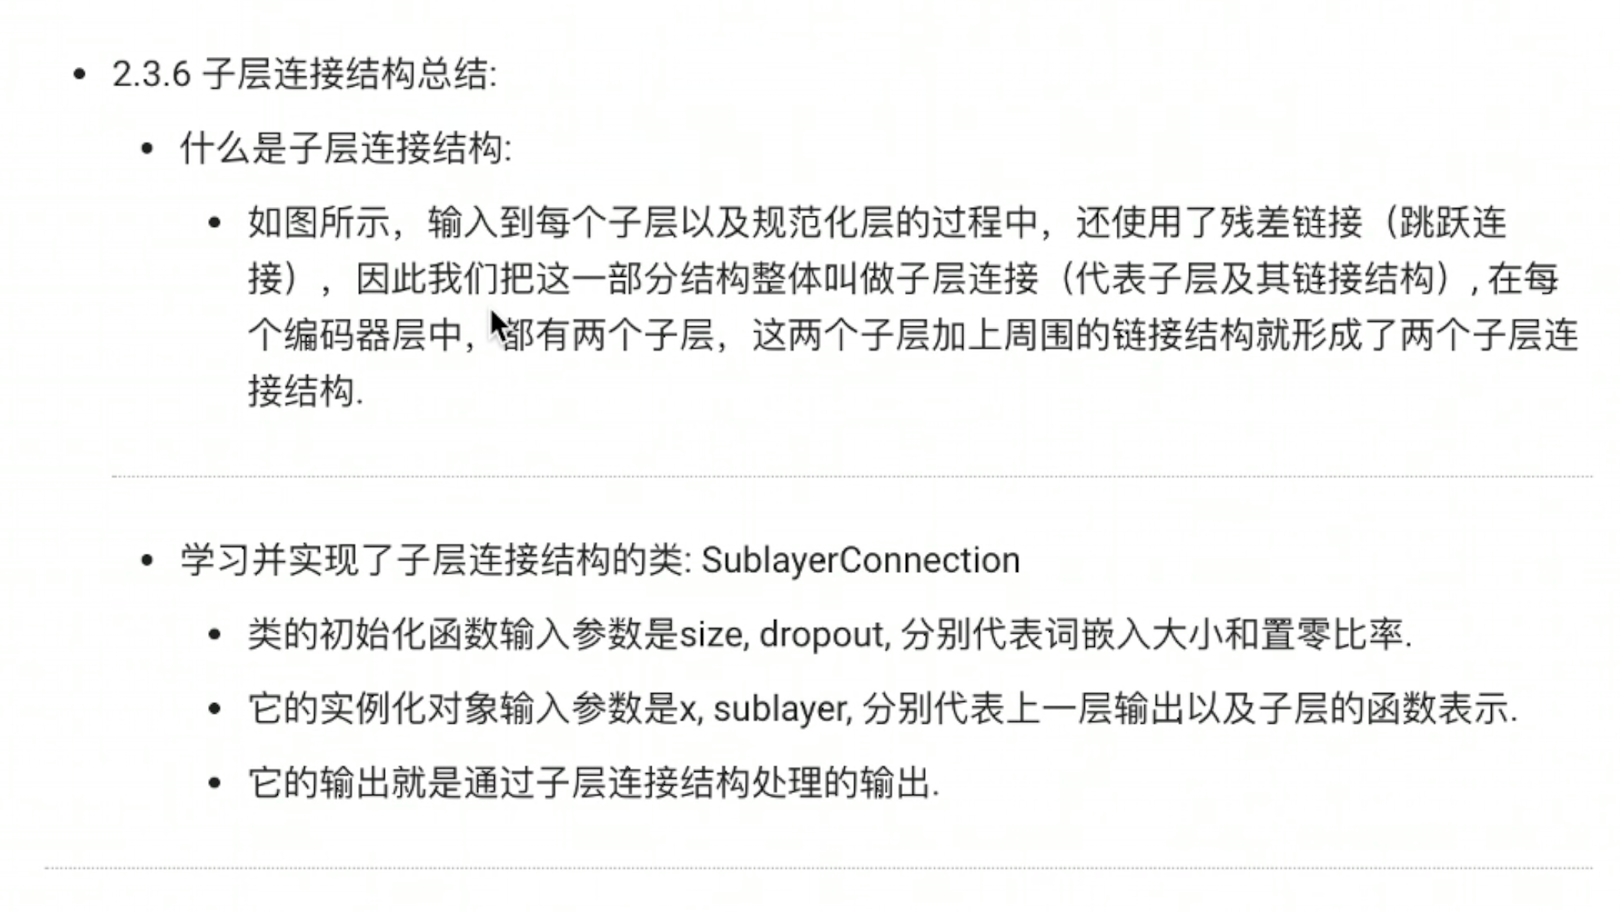